<a href="https://colab.research.google.com/github/losirlu1411/project-/blob/main/tuberculosis_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
### 1. Imports and Configuration
import os
import random
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, Conv2D, MaxPooling2D, Input
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.metrics import Recall
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.applications import VGG16, DenseNet201, ResNet101
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


In [2]:

# Dataset path
base_path = '/content/drive/MyDrive/project /TB_Chest_Radiography_Database'

# Class labels
labels = ['Normal', 'Tuberculosis']
image_size = 224

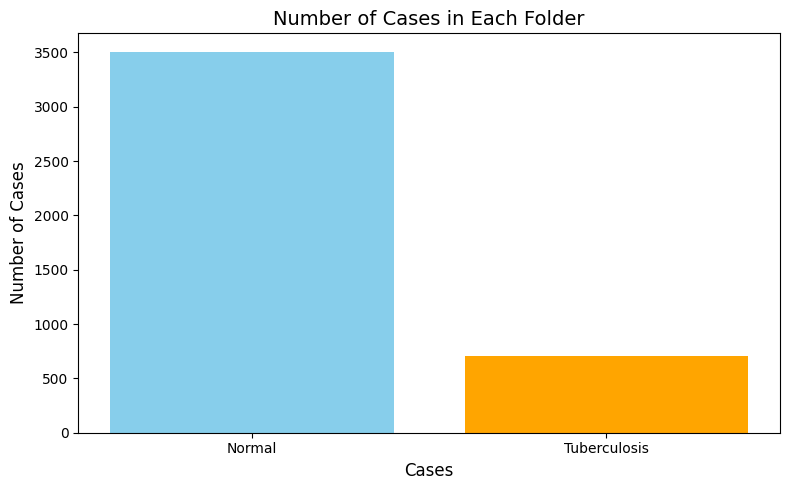

In [3]:
# Dictionary to store the count of cases per folder
case_counts = {}

labels = ['Normal', 'Tuberculosis']
# Count the number of files in each folder
for label in labels:
    folder_path = os.path.join(base_path, label)
    case_counts[label] = len(os.listdir(folder_path))


# Bar plot to visualize the number of cases
plt.figure(figsize=(8, 5))
# Use case_counts instead of cases_count
bars = plt.bar(case_counts.keys(), case_counts.values(), color=['skyblue', 'orange'])  # Different colors for each label

# Set plot title and labels
plt.title("Number of Cases in Each Folder", fontsize=14)
plt.xlabel("Cases", fontsize=12)
plt.ylabel("Number of Cases", fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()

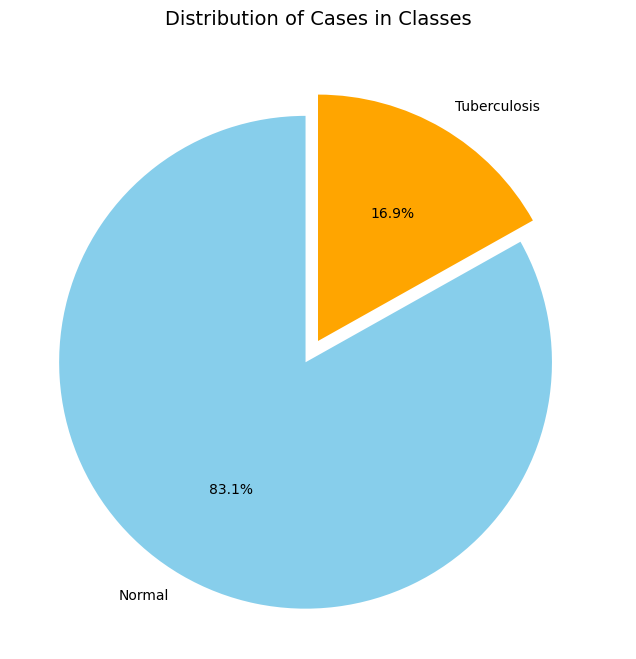

In [4]:
#Number of cases per class
cases_count = [len(os.listdir(os.path.join(base_path, label))) for label in labels]

# Plot the pie chart
plt.figure(figsize=(8, 8))
plt.pie(
    cases_count,
    labels=labels,  # Class names
    autopct='%1.1f%%',  # Show percentages
    startangle=90,  # Rotate the pie chart for better visualization
    colors=['skyblue', 'orange'],  # Assign colors
    explode=(0.1, 0)  # Slightly separate the first slice for emphasis
)

# Add a title
plt.title("Distribution of Cases in Classes", fontsize=14)
plt.show()

In [5]:
### 2. Data Loading and Preprocessing
# Function to load and preprocess images with optional sampling
def load_data(base_path, labels, image_size, sample_size):
    data, label_list = [], []
    for label_idx, label in enumerate(labels):
        folder_path = os.path.join(base_path, label)
        all_files = os.listdir(folder_path)
        if sample_size:
            sampled_files = random.sample(all_files, min(len(all_files), sample_size))
        else:
            sampled_files = all_files
        for file_name in sampled_files:
            img_path = os.path.join(folder_path, file_name)
            img = cv2.imread(img_path)
            img = cv2.resize(img, (224, 224))
            data.append(img)
            label_list.append(label_idx)
    return np.array(data), np.array(label_list)



In [6]:
# Load dataset with all samples
print("Loading full dataset...")
x_data_full, y_data_full = load_data(base_path, labels, image_size,sample_size=None)
x_data_full = x_data_full / 255.0  # Normalize images
y_data_full = to_categorical(y_data_full, num_classes=len(labels))  # One-hot encode labels
print(f"Total images loaded: {len(x_data_full)}")



Loading full dataset...
Total images loaded: 4210


In [7]:
# Split into train and test sets for both datasets
x_train_full, x_test_full, y_train_full, y_test_full = train_test_split(x_data_full, y_data_full, test_size=0.2, random_state=42)


In [8]:
### 3. Class Weights and Data Augmentation
# Compute class weights for both datasets
class_weights_full = class_weight.compute_class_weight(
    'balanced',
    classes=np.unique(np.argmax(y_train_full, axis=1)),
    y=np.argmax(y_train_full, axis=1)
)
class_weights_dict_full = {i: weight for i, weight in enumerate(class_weights_full)}

# Data augmentation for training
train_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)
train_datagen.fit(x_train_full)


In [9]:
### 4. Model Building
# Function to build a custom CNN model
def build_custom_model(input_shape, num_classes):
    model = Sequential([
        Input(shape=input_shape),
        Conv2D(32, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(256, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(
        optimizer='adam',
        loss=CategoricalCrossentropy(label_smoothing=0.1),
        metrics=['accuracy', Recall(class_id=1, name="recall")]
    )
    return model

# Function to build pretrained models
def build_pretrained_model(base_model, input_shape, num_classes):
    base_model.trainable = False
    model = Sequential([
        base_model,
        Flatten(),
        Dense(256, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(
        optimizer='adam',
        loss=CategoricalCrossentropy(label_smoothing=0.1),
        metrics=['accuracy', Recall(class_id=1, name="recall")]
    )
    return model

In [10]:
### 5. Training and Evaluation Framework
# Function to train and evaluate model
def train_and_evaluate_model(model, model_name, x_train, y_train, x_test, y_test, datagen, class_weights):
    print(f"Training {model_name}...")
    early_stopping = EarlyStopping(patience=5, restore_best_weights=True)
    history = model.fit(
        datagen.flow(x_train, y_train, batch_size=32),
        validation_data=(x_test, y_test),
        epochs=20,
        class_weight=class_weights,
        callbacks=[early_stopping],
        verbose=1
    )
    print(f"Evaluating {model_name}...")
    y_pred_probs = model.predict(x_test)
    y_pred = np.argmax(y_pred_probs, axis=1)
    y_true = np.argmax(y_test, axis=1)
    print(f"Classification Report for {model_name}:")
    print(classification_report(y_true, y_pred, target_names=labels))
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.title(f'Confusion Matrix - {model_name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()
    return history

Training Custom CNN (Full Dataset)...
Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


106/106 ━━━━━━━━━━━━━━━━━━━━ 46s 347ms/step - accuracy: 0.6077 - loss: 1.0985 - recall: 0.5449 - val_accuracy: 0.7328 - val_loss: 0.5754 - val_recall: 0.9635
Epoch 2/20
106/106 ━━━━━━━━━━━━━━━━━━━━ 33s 286ms/step - accuracy: 0.8306 - loss: 0.5329 - recall: 0.6513 - val_accuracy: 0.8943 - val_loss: 0.4914 - val_recall: 0.6058
Epoch 3/20
106/106 ━━━━━━━━━━━━━━━━━━━━ 33s 288ms/step - accuracy: 0.8453 - loss: 0.5181 - recall: 0.6743 - val_accuracy: 0.9169 - val_loss: 0.3505 - val_recall: 0.5401
Epoch 4/20
106/106 ━━━━━━━━━━━━━━━━━━━━ 33s 287ms/step - accuracy: 0.8760 - loss: 0.4454 - recall: 0.8321 - val_accuracy: 0.9454 - val_loss: 0.3210 - val_recall: 0.8321
Epoch 5/20
106/106 ━━━━━━━━━━━━━━━━━━━━ 33s 289ms/step - accuracy: 0.8410 - loss: 0.4530 - recall: 0.8424 - val_accuracy: 0.9561 - val_loss: 0.3461 - val_recall: 0.7956
Epoch 6/20
106/106 ━━━━━━━━━━━━━━━━━━━━ 33s 287ms/step - accuracy: 0.8841 - loss: 0.3903 - recall: 0.8846 - val_accuracy: 0.9371 - val_loss: 0.3258 - val_recall: 0.82

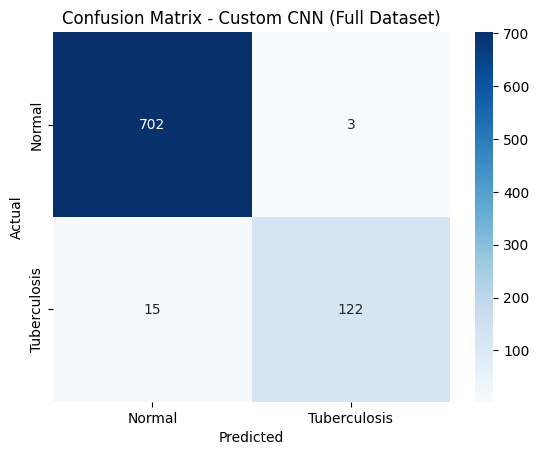

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step
Training VGG16 (Full Dataset)...
Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


106/106 ━━━━━━━━━━━━━━━━━━━━ 43s 343ms/step - accuracy: 0.7100 - loss: 1.7307 - recall: 0.6643 - val_accuracy: 0.9489 - val_loss: 0.2938 - val_recall: 0.9124
Epoch 2/20
106/106 ━━━━━━━━━━━━━━━━━━━━ 33s 293ms/step - accuracy: 0.8965 - loss: 0.3886 - recall: 0.8920 - val_accuracy: 0.9834 - val_loss: 0.2561 - val_recall: 0.9197
Epoch 3/20
106/106 ━━━━━━━━━━━━━━━━━━━━ 33s 293ms/step - accuracy: 0.8916 - loss: 0.3852 - recall: 0.8840 - val_accuracy: 0.9691 - val_loss: 0.2660 - val_recall: 0.9562
Epoch 4/20
106/106 ━━━━━━━━━━━━━━━━━━━━ 33s 292ms/step - accuracy: 0.9032 - loss: 0.3610 - recall: 0.9173 - val_accuracy: 0.9786 - val_loss: 0.2582 - val_recall: 0.9708
Epoch 5/20
106/106 ━━━━━━━━━━━━━━━━━━━━ 33s 292ms/step - accuracy: 0.9151 - loss: 0.3763 - recall: 0.9215 - val_accuracy: 0.9881 - val_loss: 0.2409 - val_recall: 0.9562
Epoch 6/20
106/106 ━━━━━━━━━━━━━━━━━━━━ 33s 290ms/step - accuracy: 0.9157 - loss: 0.3506 - recall: 0.9294 - val_accuracy: 0.9798 - val_loss: 0.2575 - val_recall: 0.97

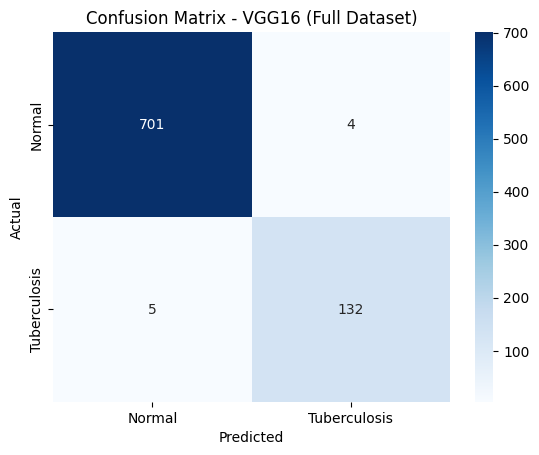

74836368/74836368 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step
Training DenseNet201 (Full Dataset)...
Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


106/106 ━━━━━━━━━━━━━━━━━━━━ 115s 714ms/step - accuracy: 0.7621 - loss: 10.2852 - recall: 0.7061 - val_accuracy: 0.9572 - val_loss: 0.2872 - val_recall: 0.7372
Epoch 2/20
106/106 ━━━━━━━━━━━━━━━━━━━━ 34s 301ms/step - accuracy: 0.9166 - loss: 0.3703 - recall: 0.8966 - val_accuracy: 0.9798 - val_loss: 0.2448 - val_recall: 0.8759
Epoch 3/20
106/106 ━━━━━━━━━━━━━━━━━━━━ 34s 300ms/step - accuracy: 0.9381 - loss: 0.3427 - recall: 0.9278 - val_accuracy: 0.9905 - val_loss: 0.2411 - val_recall: 0.9562
Epoch 4/20
106/106 ━━━━━━━━━━━━━━━━━━━━ 33s 294ms/step - accuracy: 0.9514 - loss: 0.3165 - recall: 0.9588 - val_accuracy: 0.9941 - val_loss: 0.2436 - val_recall: 0.9854
Epoch 5/20
106/106 ━━━━━━━━━━━━━━━━━━━━ 34s 298ms/step - accuracy: 0.9440 - loss: 0.3265 - recall: 0.9440 - val_accuracy: 0.9941 - val_loss: 0.2328 - val_recall: 0.9708
Epoch 6/20
106/106 ━━━━━━━━━━━━━━━━━━━━ 34s 298ms/step - accuracy: 0.9540 - loss: 0.3163 - recall: 0.9369 - val_accuracy: 0.9976 - val_loss: 0.2351 - val_recall: 0.

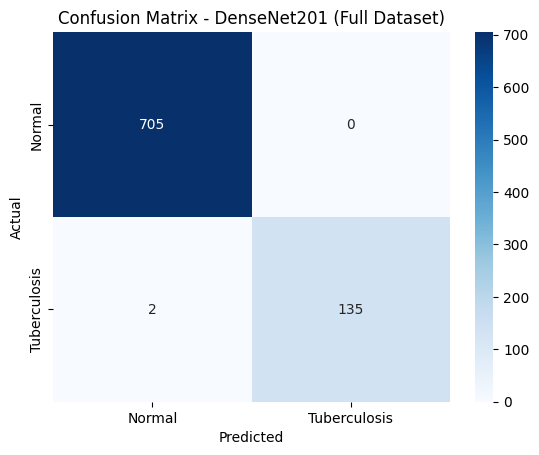

171446536/171446536 ━━━━━━━━━━━━━━━━━━━━ 8s 0us/step
Training ResNet101 (Full Dataset)...
Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


106/106 ━━━━━━━━━━━━━━━━━━━━ 66s 440ms/step - accuracy: 0.4091 - loss: 3.8692 - recall: 0.5913 - val_accuracy: 0.8373 - val_loss: 0.6906 - val_recall: 0.0073
Epoch 2/20
106/106 ━━━━━━━━━━━━━━━━━━━━ 33s 295ms/step - accuracy: 0.7153 - loss: 0.7095 - recall: 0.2128 - val_accuracy: 0.8373 - val_loss: 0.6914 - val_recall: 0.0073
Epoch 3/20
106/106 ━━━━━━━━━━━━━━━━━━━━ 33s 294ms/step - accuracy: 0.7474 - loss: 0.7030 - recall: 0.2105 - val_accuracy: 0.6235 - val_loss: 0.6946 - val_recall: 0.6715
Epoch 4/20
106/106 ━━━━━━━━━━━━━━━━━━━━ 34s 296ms/step - accuracy: 0.7110 - loss: 0.6964 - recall: 0.2507 - val_accuracy: 0.8385 - val_loss: 0.6837 - val_recall: 0.0073
Epoch 5/20
106/106 ━━━━━━━━━━━━━━━━━━━━ 33s 294ms/step - accuracy: 0.8374 - loss: 0.6809 - recall: 8.5219e-04 - val_accuracy: 0.8373 - val_loss: 0.6877 - val_recall: 0.0073
Epoch 6/20
106/106 ━━━━━━━━━━━━━━━━━━━━ 33s 292ms/step - accuracy: 0.7937 - loss: 0.7016 - recall: 0.0333 - val_accuracy: 0.8385 - val_loss: 0.6886 - val_recall: 

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


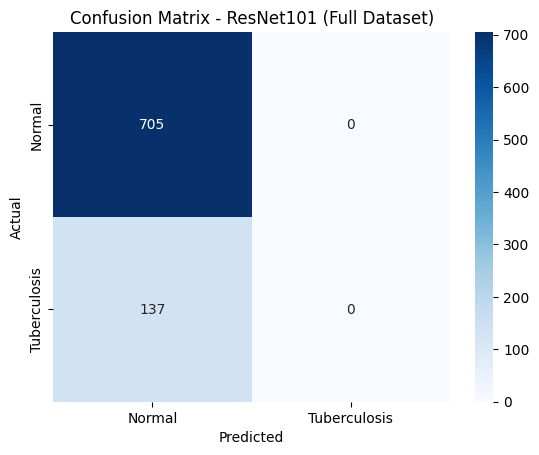

In [11]:
### 6. Model Training
# Define input shape and number of classes
input_shape = (image_size, image_size, 3)
num_classes = len(labels)

# Custom Model
custom_model_full = build_custom_model(input_shape, num_classes)
custom_history_full = train_and_evaluate_model(custom_model_full, "Custom CNN (Full Dataset)", x_train_full, y_train_full, x_test_full, y_test_full, train_datagen, class_weights_dict_full)


# VGG16
vgg16_base = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)
vgg16_model_full = build_pretrained_model(vgg16_base, input_shape, num_classes)
vgg16_history_full = train_and_evaluate_model(vgg16_model_full, "VGG16 (Full Dataset)", x_train_full, y_train_full, x_test_full, y_test_full, train_datagen, class_weights_dict_full)

# DenseNet201
densenet_base = DenseNet201(weights='imagenet', include_top=False, input_shape=input_shape)
densenet_model_full = build_pretrained_model(densenet_base, input_shape, num_classes)
densenet_history_full = train_and_evaluate_model(densenet_model_full, "DenseNet201 (Full Dataset)", x_train_full, y_train_full, x_test_full, y_test_full, train_datagen, class_weights_dict_full)

# ResNet101
resnet_base = ResNet101(weights='imagenet', include_top=False, input_shape=input_shape)
resnet_model_full = build_pretrained_model(resnet_base, input_shape, num_classes)
resnet_history_full = train_and_evaluate_model(resnet_model_full, "ResNet101 (Full Dataset)", x_train_full, y_train_full, x_test_full, y_test_full, train_datagen, class_weights_dict_full)


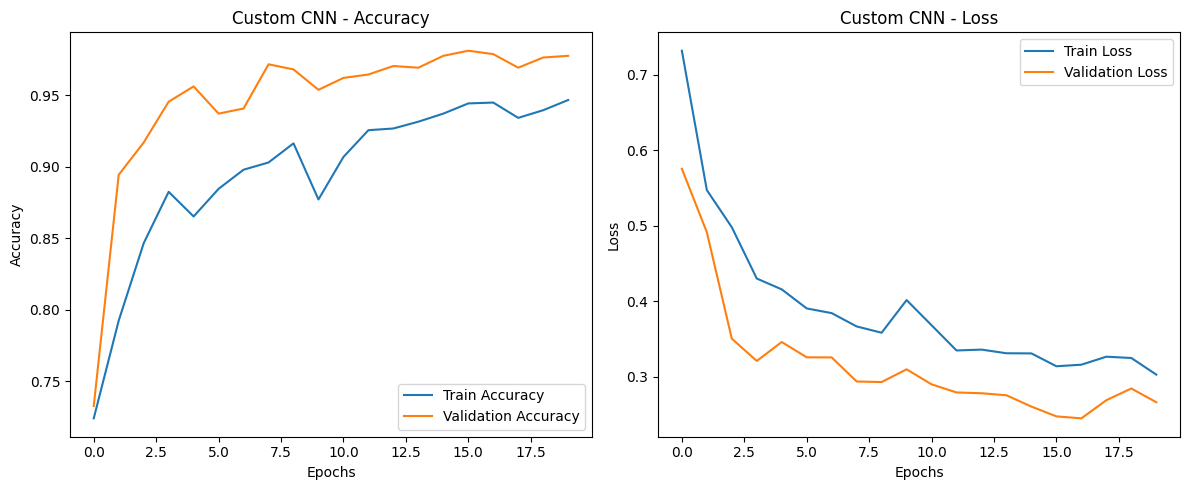

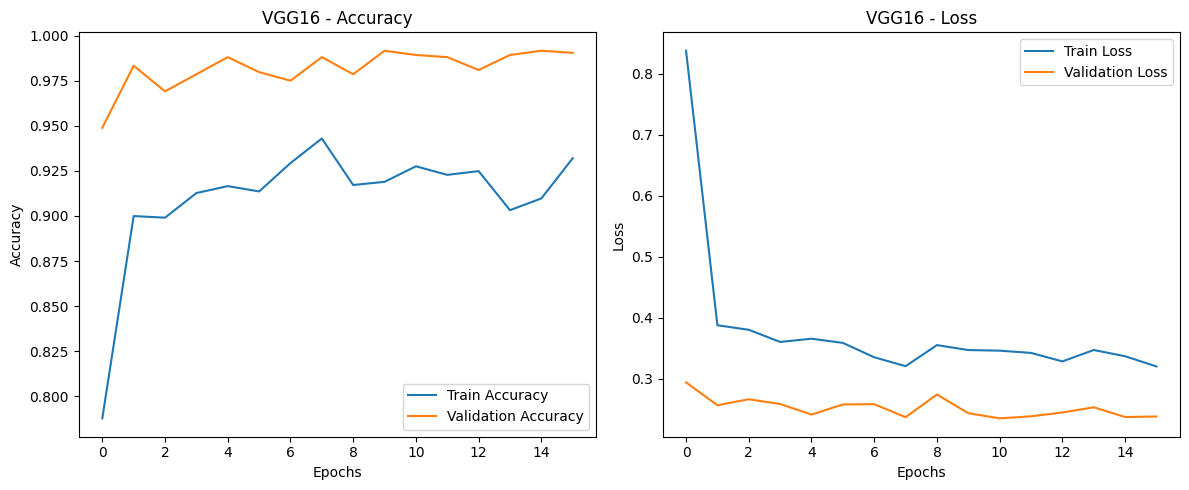

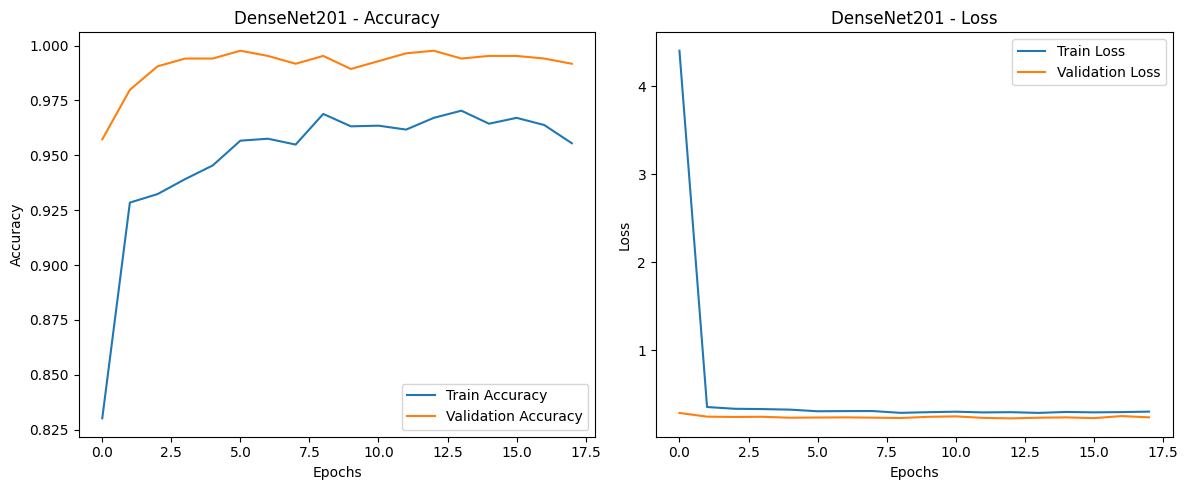

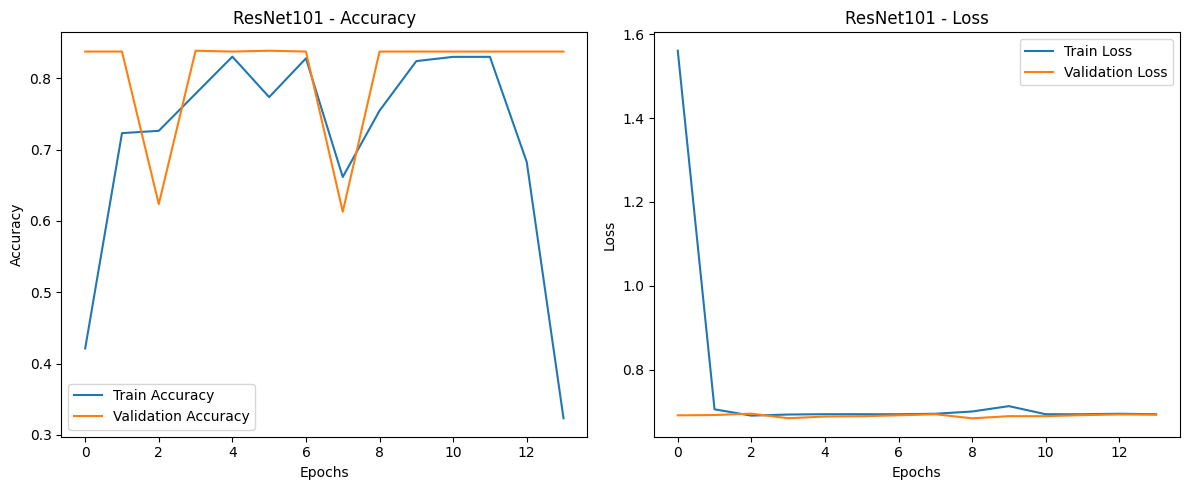

In [12]:
# 7 Plot individual models
models = {
    "Custom CNN": custom_history_full,
    "VGG16": vgg16_history_full,
    "DenseNet201": densenet_history_full,
    "ResNet101": resnet_history_full,

}

for model_name, history in models.items():
    plt.figure(figsize=(12, 5))

    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'{model_name} - Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'{model_name} - Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()


Predictions for Full Dataset
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 407ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


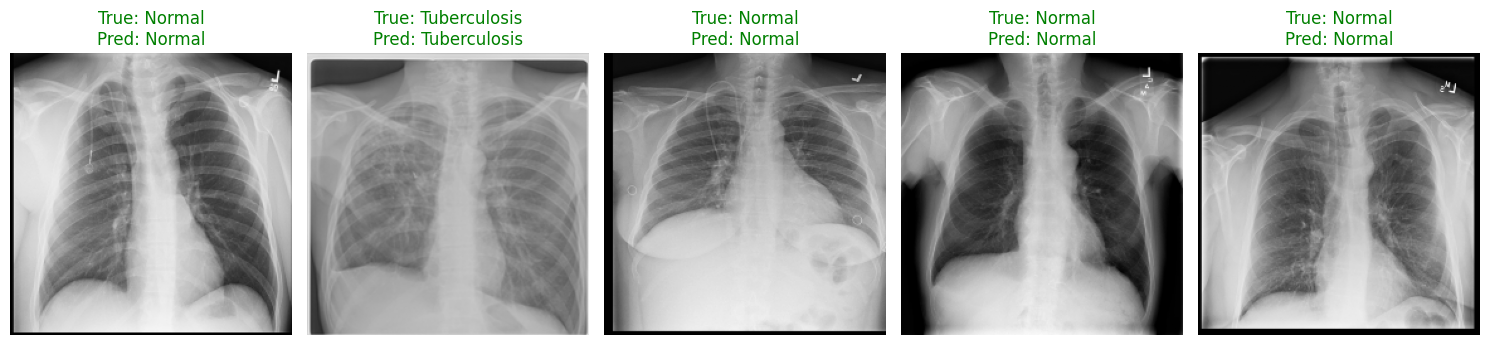

In [13]:
### 8. Predict and Display Images
# Function to display predictions for 5 random images
def display_predictions(model, x_test, y_test, labels, num_images=5):
    indices = np.random.choice(len(x_test), num_images, replace=False)
    plt.figure(figsize=(15, 10))
    for i, idx in enumerate(indices):
        plt.subplot(1, num_images, i + 1)
        img = x_test[idx]
        true_label = labels[np.argmax(y_test[idx])]
        pred_label = labels[np.argmax(model.predict(img[np.newaxis, ...]))]
        color = 'green' if true_label == pred_label else 'red'
        plt.imshow(img)
        plt.title(f"True: {true_label}\nPred: {pred_label}", color=color)
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Example usage:
print("Predictions for Full Dataset")
display_predictions(custom_model_full, x_test_full, y_test_full, labels, num_images=5)


27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step
         Model  Accuracy  Precision    Recall  F1-Score
0        VGG16  0.989311   0.989285  0.989311  0.989295
1    ResNet101  0.837292   0.701058  0.837292  0.763143
2   Custom CNN  0.978622   0.978578  0.978622  0.978223
3  DenseNet201  0.997625   0.997631  0.997625  0.997618


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


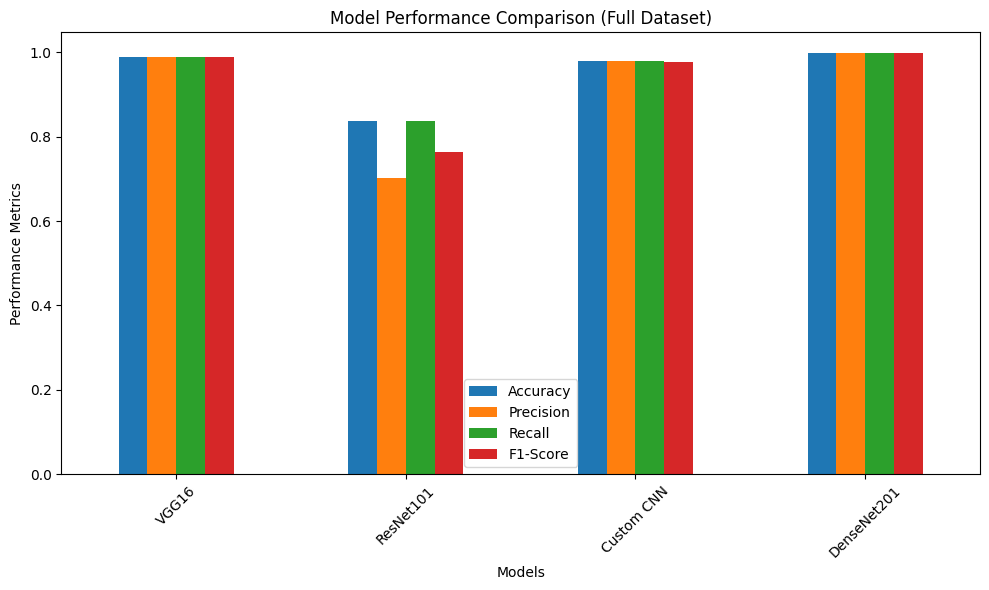

In [14]:
# 9 Predictions for each individual model

vgg_preds_full = np.argmax(vgg16_model_full.predict(x_test_full), axis=1)
resnet_preds_full = np.argmax(resnet_model_full.predict(x_test_full), axis=1)
custom_preds_full = np.argmax(custom_model_full.predict(x_test_full), axis=1)
densenet_preds_full = np.argmax(densenet_model_full.predict(x_test_full), axis=1)

# True labels
y_true_full = np.argmax(y_test_full, axis=1)



# Evaluation function
def evaluate_model(y_true, y_pred, model_name):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')
    return {"Model": model_name, "Accuracy": accuracy, "Precision": precision, "Recall": recall, "F1-Score": f1}

# Evaluate models for the full dataset
results_full = []
results_full.append(evaluate_model(y_true_full, vgg_preds_full, "VGG16"))
results_full.append(evaluate_model(y_true_full, resnet_preds_full, "ResNet101"))
results_full.append(evaluate_model(y_true_full, custom_preds_full, "Custom CNN"))
results_full.append(evaluate_model(y_true_full, densenet_preds_full, "DenseNet201"))

# Convert results to DataFrames for comparison
results_full_df = pd.DataFrame(results_full)

# Display the results
print(results_full_df)

# Bar plot for the full dataset
results_full_df.set_index("Model").plot(kind='bar', figsize=(10, 6))
plt.title("Model Performance Comparison (Full Dataset)")
plt.xlabel("Models")
plt.ylabel("Performance Metrics")
plt.xticks(rotation=45)
plt.legend(loc="best")
plt.tight_layout()
plt.show()



In [15]:
# Load dataset with 500 samples per class
print("Loading sampled dataset (500 per class)...")
x_data_sampled, y_data_sampled = load_data(base_path, labels, image_size, sample_size=500)
x_data_sampled = x_data_sampled / 255.0  # Normalize images
y_data_sampled = to_categorical(y_data_sampled, num_classes=len(labels))  # One-hot encode labels
print(f"Total images loaded: {len(x_data_sampled)}")

Loading sampled dataset (500 per class)...
Total images loaded: 1000


In [16]:
# Split into train and test sets for both datasets
x_train_sampled, x_test_sampled, y_train_sampled, y_test_sampled = train_test_split(x_data_sampled, y_data_sampled, test_size=0.2, random_state=42)

In [17]:
### 3. Class Weights and Data Augmentation
# Compute class weights for both datasets

class_weights_sampled = class_weight.compute_class_weight(
    'balanced',
    classes=np.unique(np.argmax(y_train_sampled, axis=1)),
    y=np.argmax(y_train_sampled, axis=1)
)
class_weights_dict_sampled = {i: weight for i, weight in enumerate(class_weights_sampled)}

# Data augmentation for training
train_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)
train_datagen.fit(x_train_sampled)

In [18]:
### 4. Model Building
# Function to build a custom CNN model
def build_custom_model(input_shape, num_classes):
    model = Sequential([
        Input(shape=input_shape),
        Conv2D(32, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        # Changed the third Conv2D layer configuration from 128 filters with (3,3) kernel to 64 filters with (3,3) kernel.
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(256, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(
        optimizer='adam',
        loss=CategoricalCrossentropy(label_smoothing=0.1),
        metrics=['accuracy', Recall(class_id=1, name="recall")]
    )
    return model

# Function to build pretrained models
def build_pretrained_model(base_model, input_shape, num_classes):
    base_model.trainable = False
    model = Sequential([
        base_model,
        Flatten(),
        Dense(256, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(
        optimizer='adam',
        loss=CategoricalCrossentropy(label_smoothing=0.1),
        metrics=['accuracy', Recall(class_id=1, name="recall")]
    )
    return model

In [19]:
### 5. Training and Evaluation Framework
# Function to train and evaluate model
def train_and_evaluate_model(model, model_name, x_train, y_train, x_test, y_test, datagen, class_weights):
    print(f"Training {model_name}...")
    early_stopping = EarlyStopping(patience=5, restore_best_weights=True)
    history = model.fit(
        datagen.flow(x_train, y_train, batch_size=32),
        validation_data=(x_test, y_test),
        epochs=20,
        class_weight=class_weights,
        callbacks=[early_stopping],
        verbose=1
    )
    print(f"Evaluating {model_name}...")
    y_pred_probs = model.predict(x_test)
    y_pred = np.argmax(y_pred_probs, axis=1)
    y_true = np.argmax(y_test, axis=1)
    print(f"Classification Report for {model_name}:")
    print(classification_report(y_true, y_pred, target_names=labels))
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.title(f'Confusion Matrix - {model_name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()
    return history

Training Custom CNN (Sampled Dataset)...
Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


25/25 ━━━━━━━━━━━━━━━━━━━━ 14s 342ms/step - accuracy: 0.5543 - loss: 1.3184 - recall: 0.6292 - val_accuracy: 0.7250 - val_loss: 0.5877 - val_recall: 0.8942
Epoch 2/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 8s 225ms/step - accuracy: 0.6227 - loss: 0.6135 - recall: 0.6668 - val_accuracy: 0.7050 - val_loss: 0.5516 - val_recall: 0.4423
Epoch 3/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 8s 227ms/step - accuracy: 0.7438 - loss: 0.5505 - recall: 0.5761 - val_accuracy: 0.6950 - val_loss: 0.5174 - val_recall: 0.4231
Epoch 4/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 8s 226ms/step - accuracy: 0.7447 - loss: 0.5263 - recall: 0.6352 - val_accuracy: 0.7800 - val_loss: 0.4574 - val_recall: 0.5962
Epoch 5/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 8s 223ms/step - accuracy: 0.8415 - loss: 0.4413 - recall: 0.7705 - val_accuracy: 0.8050 - val_loss: 0.4636 - val_recall: 0.6442
Epoch 6/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 8s 225ms/step - accuracy: 0.8659 - loss: 0.4378 - recall: 0.8426 - val_accuracy: 0.7750 - val_loss: 0.4612 - val_recall: 0.5769
Epoch 7/20
25/

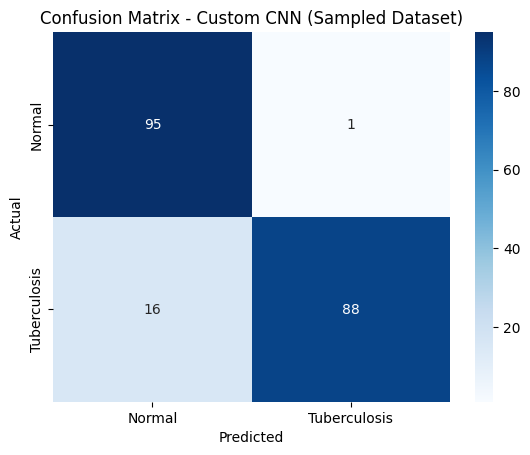

Training VGG16 (Sampled Dataset)...
Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


25/25 ━━━━━━━━━━━━━━━━━━━━ 13s 330ms/step - accuracy: 0.5975 - loss: 3.0068 - recall: 0.6110 - val_accuracy: 0.9200 - val_loss: 0.3509 - val_recall: 0.9135
Epoch 2/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 8s 232ms/step - accuracy: 0.7909 - loss: 0.4907 - recall: 0.8350 - val_accuracy: 0.9400 - val_loss: 0.3395 - val_recall: 0.9135
Epoch 3/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 8s 231ms/step - accuracy: 0.8688 - loss: 0.4273 - recall: 0.8746 - val_accuracy: 0.9450 - val_loss: 0.3041 - val_recall: 0.9423
Epoch 4/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 8s 232ms/step - accuracy: 0.8966 - loss: 0.4018 - recall: 0.8977 - val_accuracy: 0.9600 - val_loss: 0.2887 - val_recall: 0.9519
Epoch 5/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 8s 233ms/step - accuracy: 0.8874 - loss: 0.3825 - recall: 0.8852 - val_accuracy: 0.9550 - val_loss: 0.2880 - val_recall: 0.9808
Epoch 6/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 8s 228ms/step - accuracy: 0.9273 - loss: 0.3470 - recall: 0.9188 - val_accuracy: 0.9550 - val_loss: 0.2969 - val_recall: 0.9904
Epoch 7/20
25/

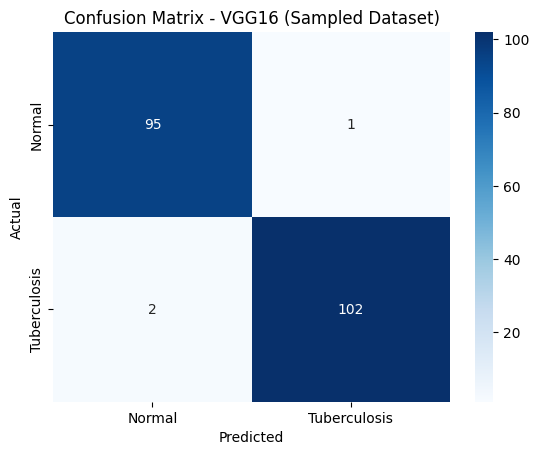

Training DenseNet201 (Sampled Dataset)...
Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


25/25 ━━━━━━━━━━━━━━━━━━━━ 59s 1s/step - accuracy: 0.6675 - loss: 7.5822 - recall: 0.6418 - val_accuracy: 0.9900 - val_loss: 1.4169 - val_recall: 1.0000
Epoch 2/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 9s 251ms/step - accuracy: 0.8484 - loss: 1.8686 - recall: 0.8685 - val_accuracy: 0.9000 - val_loss: 0.3828 - val_recall: 0.8077
Epoch 3/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 9s 250ms/step - accuracy: 0.9227 - loss: 0.3732 - recall: 0.9192 - val_accuracy: 0.9650 - val_loss: 0.3023 - val_recall: 0.9327
Epoch 4/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 8s 248ms/step - accuracy: 0.9371 - loss: 0.3462 - recall: 0.9285 - val_accuracy: 0.9650 - val_loss: 0.2902 - val_recall: 0.9327
Epoch 5/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 8s 238ms/step - accuracy: 0.9248 - loss: 0.3495 - recall: 0.9269 - val_accuracy: 0.9450 - val_loss: 0.2993 - val_recall: 0.8942
Epoch 6/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 9s 251ms/step - accuracy: 0.9518 - loss: 0.3319 - recall: 0.9478 - val_accuracy: 0.9800 - val_loss: 0.2553 - val_recall: 0.9615
Epoch 7/20
25/25 

7/7 ━━━━━━━━━━━━━━━━━━━━ 25s 2s/step
Classification Report for DenseNet201 (Sampled Dataset):
              precision    recall  f1-score   support

      Normal       0.99      0.99      0.99        96
Tuberculosis       0.99      0.99      0.99       104

    accuracy                           0.99       200
   macro avg       0.99      0.99      0.99       200
weighted avg       0.99      0.99      0.99       200



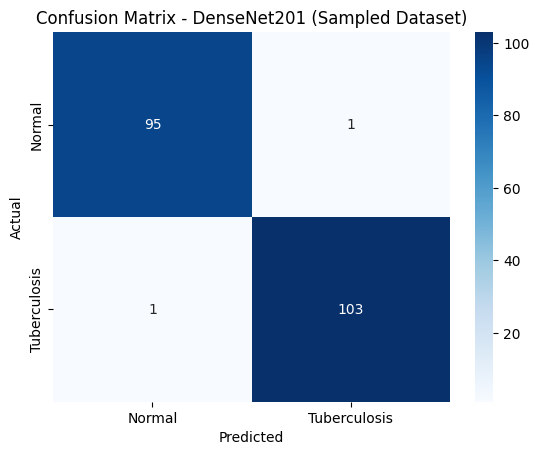

Training ResNet101 (Sampled Dataset)...
Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


25/25 ━━━━━━━━━━━━━━━━━━━━ 33s 628ms/step - accuracy: 0.5116 - loss: 5.3741 - recall: 0.5387 - val_accuracy: 0.5200 - val_loss: 0.6856 - val_recall: 1.0000
Epoch 2/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 8s 233ms/step - accuracy: 0.5359 - loss: 0.7122 - recall: 0.2012 - val_accuracy: 0.4800 - val_loss: 0.6933 - val_recall: 0.0000e+00
Epoch 3/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 8s 235ms/step - accuracy: 0.5014 - loss: 0.6944 - recall: 0.0981 - val_accuracy: 0.4800 - val_loss: 0.6933 - val_recall: 0.0000e+00
Epoch 4/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 8s 234ms/step - accuracy: 0.4928 - loss: 0.6936 - recall: 0.0103 - val_accuracy: 0.5200 - val_loss: 0.7049 - val_recall: 1.0000
Epoch 5/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 8s 234ms/step - accuracy: 0.5014 - loss: 0.6963 - recall: 0.1188 - val_accuracy: 0.4800 - val_loss: 0.6932 - val_recall: 0.0000e+00
Epoch 6/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 8s 235ms/step - accuracy: 0.5113 - loss: 0.6930 - recall: 0.0000e+00 - val_accuracy: 0.4800 - val_loss: 0.6933 - val_recall: 0.000

7/7 ━━━━━━━━━━━━━━━━━━━━ 12s 953ms/step
Classification Report for ResNet101 (Sampled Dataset):
              precision    recall  f1-score   support

      Normal       0.00      0.00      0.00        96
Tuberculosis       0.52      1.00      0.68       104

    accuracy                           0.52       200
   macro avg       0.26      0.50      0.34       200
weighted avg       0.27      0.52      0.36       200



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


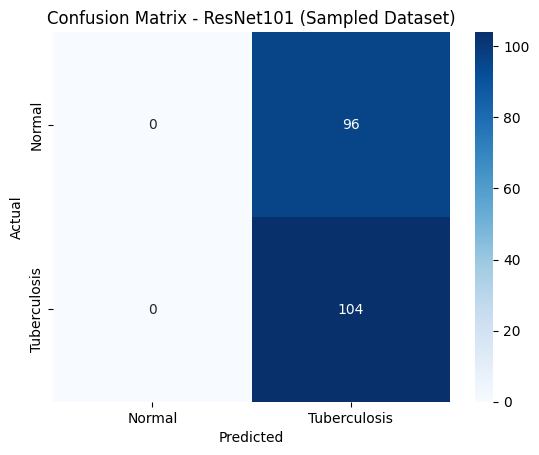

In [20]:
### 6. Model Training
# Define input shape and number of classes
input_shape = (image_size, image_size, 3)
num_classes = len(labels)

# Custom Model
custom_model_sampled = build_custom_model(input_shape, num_classes)
custom_history_sampled = train_and_evaluate_model(custom_model_sampled, "Custom CNN (Sampled Dataset)", x_train_sampled, y_train_sampled, x_test_sampled, y_test_sampled, train_datagen, class_weights_dict_sampled)

# VGG16
vgg16_base = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)
vgg16_model_sampled = build_pretrained_model(vgg16_base, input_shape, num_classes)
vgg16_history_sampled = train_and_evaluate_model(vgg16_model_sampled, "VGG16 (Sampled Dataset)", x_train_sampled, y_train_sampled, x_test_sampled, y_test_sampled, train_datagen, class_weights_dict_sampled)

# DenseNet201
densenet_base = DenseNet201(weights='imagenet', include_top=False, input_shape=input_shape)
densenet_model_sampled = build_pretrained_model(densenet_base, input_shape, num_classes)
densenet_history_sampled = train_and_evaluate_model(densenet_model_sampled, "DenseNet201 (Sampled Dataset)", x_train_sampled, y_train_sampled, x_test_sampled, y_test_sampled, train_datagen, class_weights_dict_sampled)

# ResNet101
resnet_base = ResNet101(weights='imagenet', include_top=False, input_shape=input_shape)
resnet_model_sampled = build_pretrained_model(resnet_base, input_shape, num_classes)
resnet_history_sampled = train_and_evaluate_model(resnet_model_sampled, "ResNet101 (Sampled Dataset)", x_train_sampled, y_train_sampled, x_test_sampled, y_test_sampled, train_datagen, class_weights_dict_sampled)

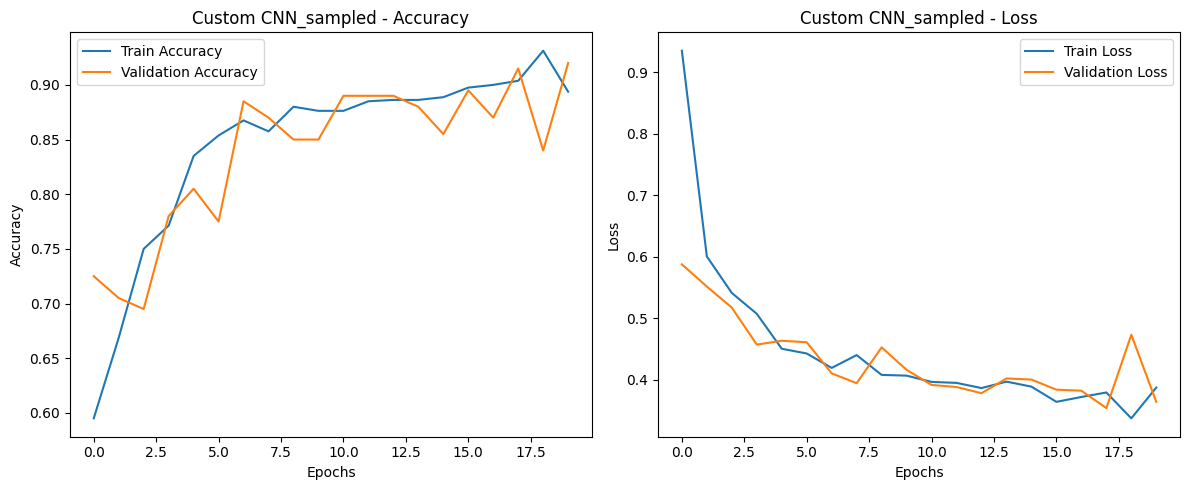

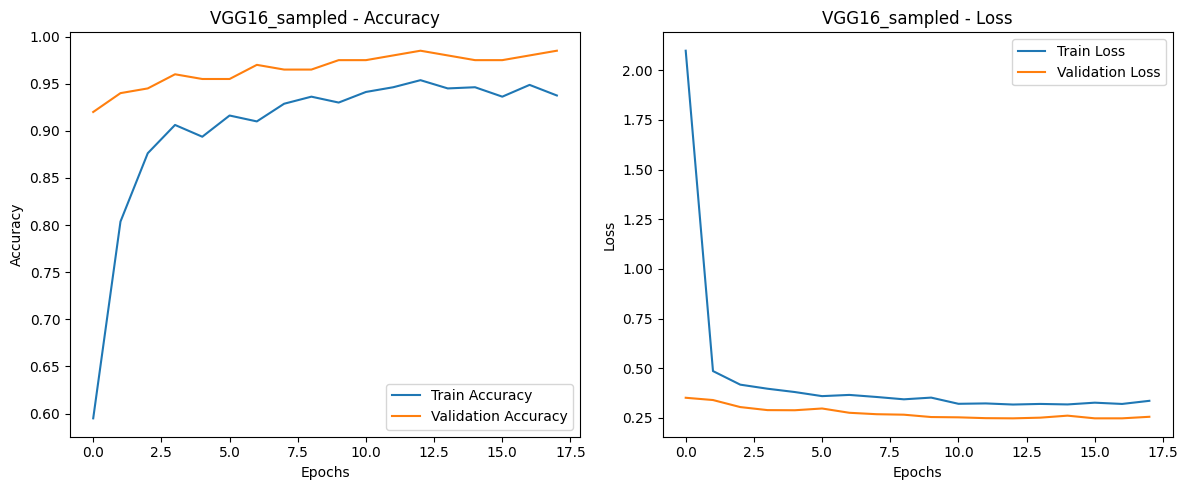

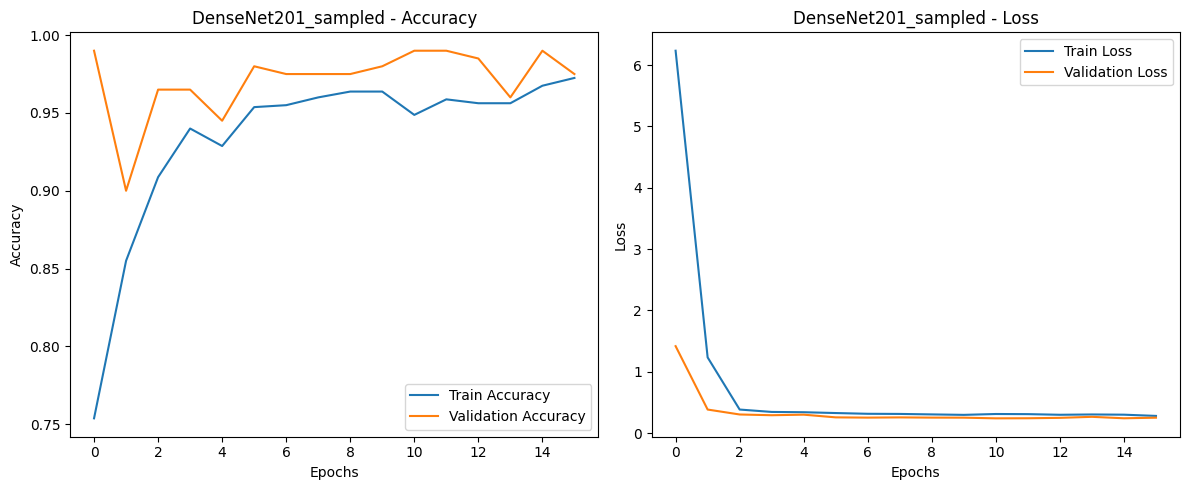

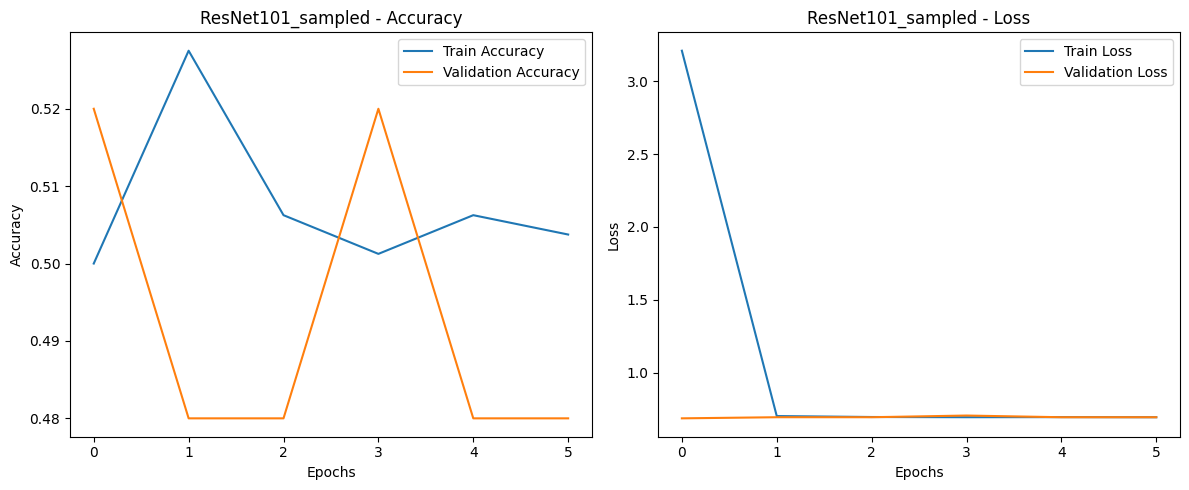

In [21]:
# 7 Plot individual models
models = {
    "Custom CNN_sampled": custom_history_sampled,
    "VGG16_sampled": vgg16_history_sampled,
    "DenseNet201_sampled": densenet_history_sampled,
    "ResNet101_sampled": resnet_history_sampled
}

for model_name, history in models.items():
    plt.figure(figsize=(12, 5))

    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'{model_name} - Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'{model_name} - Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()


Predictions for Sampled Dataset
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


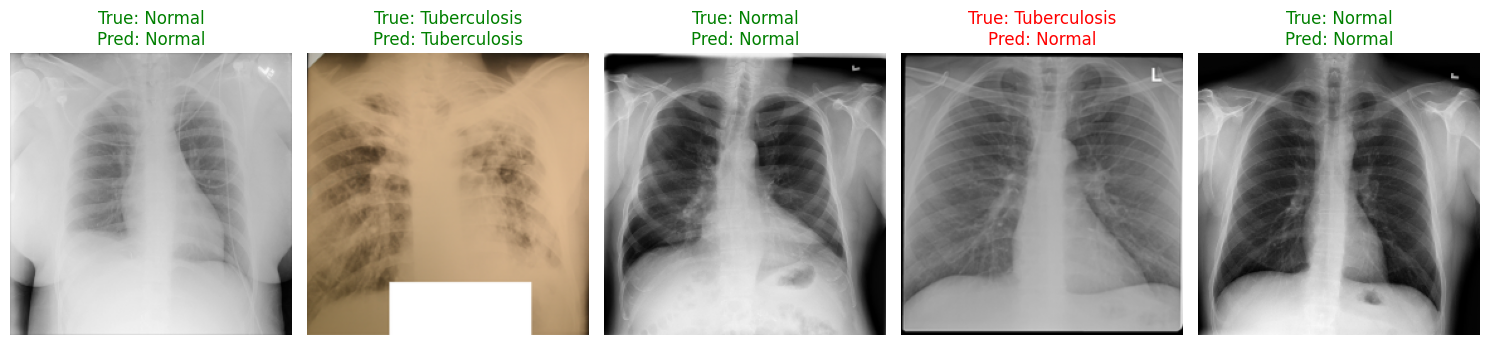

In [22]:
### 8. Predict and Display Images
# Function to display predictions for 5 random images
def display_predictions(model, x_test, y_test, labels, num_images=5):
    indices = np.random.choice(len(x_test), num_images, replace=False)
    plt.figure(figsize=(15, 10))
    for i, idx in enumerate(indices):
        plt.subplot(1, num_images, i + 1)
        img = x_test[idx]
        true_label = labels[np.argmax(y_test[idx])]
        pred_label = labels[np.argmax(model.predict(img[np.newaxis, ...]))]
        color = 'green' if true_label == pred_label else 'red'
        plt.imshow(img)
        plt.title(f"True: {true_label}\nPred: {pred_label}", color=color)
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Example usage:
print("Predictions for Sampled Dataset")
display_predictions(custom_model_sampled, x_test_sampled, y_test_sampled, labels, num_images=5)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
         Model  Accuracy  Precision  Recall  F1-Score
0        VGG16     0.985   0.985055   0.985  0.985003
1    ResNet101     0.520   0.270400   0.520  0.355789
2   Custom CNN     0.915   0.924968   0.915  0.914777
3  DenseNet201     0.990   0.990000   0.990  0.990000


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


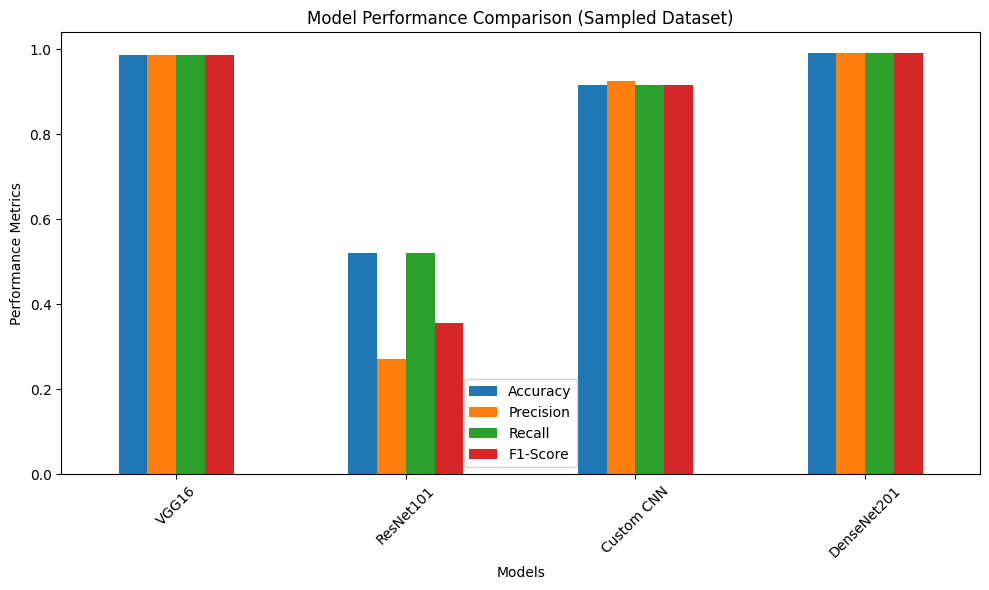

In [23]:
# 9 Predictions for each individual model
vgg_preds_sampled = np.argmax(vgg16_model_sampled.predict(x_test_sampled), axis=1)
resnet_preds_sampled = np.argmax(resnet_model_sampled.predict(x_test_sampled), axis=1)
custom_preds_sampled = np.argmax(custom_model_sampled.predict(x_test_sampled), axis=1)
densenet_preds_sampled = np.argmax(densenet_model_sampled.predict(x_test_sampled), axis=1)

# True labels
y_true_sampled = np.argmax(y_test_sampled, axis=1)

# Evaluation function
def evaluate_model(y_true, y_pred, model_name):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')
    return {"Model": model_name, "Accuracy": accuracy, "Precision": precision, "Recall": recall, "F1-Score": f1}



# Evaluate models for the sampled dataset
results_sampled = []
results_sampled.append(evaluate_model(y_true_sampled, vgg_preds_sampled, "VGG16"))
results_sampled.append(evaluate_model(y_true_sampled, resnet_preds_sampled, "ResNet101"))
results_sampled.append(evaluate_model(y_true_sampled, custom_preds_sampled, "Custom CNN"))
results_sampled.append(evaluate_model(y_true_sampled, densenet_preds_sampled, "DenseNet201"))


# Convert results to DataFrames for comparison
results_sampled_df = pd.DataFrame(results_sampled)
print(results_sampled_df)
# Bar plot for the sampled dataset
results_sampled_df.set_index("Model").plot(kind='bar', figsize=(10, 6))
plt.title("Model Performance Comparison (Sampled Dataset)")
plt.xlabel("Models")
plt.ylabel("Performance Metrics")
plt.xticks(rotation=45)
plt.legend(loc="best")
plt.tight_layout()
plt.show()
